**In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.**

**Contents : **
1. **Exploration**

2.    **Outliers Removal**

3.    **Feature Extraction**

4.    **Model Preparation**

5.    **Results **

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
#sample=pd.read_csv('sample_submission.csv')
test=pd.read_csv('test.csv')

In [3]:
import gc
gc.collect()

0

In [4]:
train=pd.read_csv('train.csv')

In [5]:
import gc
gc.collect()

0

1.**Exploration**

In [6]:
#print(sample.head())
#print('\n',test.head())
#print('\n',train.head())

In [7]:
print(test.shape)
print(train.shape)

(625134, 9)
(1458644, 11)


In [8]:
#print(test.columns)
#print(train.columns)

In [9]:
#print(test.isnull().sum())
#print(train.isnull().sum())

In [10]:
#print(test.info())
#print(train.info())
#print('\n\n',test.describe(),'\n\n',train.describe())

2.**Outliers detection and removal**

In [11]:
#Converting Trip duration in Hours
train['trip_dur_hr']=train['trip_duration']/3600
print(train['trip_dur_hr'].describe(),'\n')

#We can see that 75 % of data have value less than or equals to 2.986111e-01 Hrs
#but max value is 9.795228e+02 Hrs(Quite Large) :> Definitly an outlier

#Checking data sufficient for removal
#print(len(train.loc[train['trip_dur_hr']>=4,['trip_dur_hr']])) gives  2077 entries
#print(len(train.loc[train['trip_dur_hr']>=2,['trip_dur_hr']])) gives 2253 entries
#print(len(train.loc[train['trip_dur_hr']>=1,['trip_dur_hr']])) gives 12334 entries
#Hence removing entries with trip_du_hr>=2 seems good

#drop above 2 hrs trip data (removing outliers)
train=train.loc[train['trip_dur_hr']<=2,[str(i) for i in train.columns]]
train['passenger_count'][train['passenger_count']>=8]=6
test['passenger_count'][test['passenger_count']>=8]=6
print(train.shape)
#print(min(train['trip_duration']),max(train.trip_duration))
#print(min(train.trip_dur_hr),max(train.trip_dur_hr),'\n\n')
#print(train['trip_dur_hr'].describe())

count    1.458644e+06
mean     2.665256e-01
std      1.454842e+00
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      9.795228e+02
Name: trip_dur_hr, dtype: float64 



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1456391, 12)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3.**Feature Extraction : **

In [12]:
# Caculating distance between pickup and dropup location
from math import sin, cos, sqrt, atan2, radians
def distance(lat1,lat2,lon1,lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance
train['distance']=[distance(i,j,k,l) for i,j,k,l in zip(train.pickup_latitude,
                                                        train.dropoff_latitude,train.pickup_longitude,
                                                        train.dropoff_longitude)]
test['distance']=[distance(i,j,k,l) for i,j,k,l in zip(test.pickup_latitude,
                                                        test.dropoff_latitude,test.pickup_longitude,
                                                        test.dropoff_longitude)]

In [13]:
import gc
gc.collect()

427

In [14]:
#Latitude and Longitude to cartesian cordindates converesion
# Assuming Earth as sphere not ellipsoid 
def cartesian_x(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    R=6371.0
    x = R * cos(lat) * cos(lon)
    return x
def cartesian_y(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    R=6371.0
    y = R * cos(lat) * sin(lon)
    return y
# extracting cartesian x,y cordinates form latitude and longitude
train['x1']=[cartesian_x(i,j) for i,j in zip(train['pickup_latitude'],train['pickup_longitude'])]
train['y1']=[cartesian_y(i,j) for i,j in zip(train['pickup_latitude'],train['pickup_longitude'])]
train['x2']=[cartesian_x(i,j) for i,j in zip(train['dropoff_latitude'],train['dropoff_longitude'])]
train['y2']=[cartesian_y(i,j) for i,j in zip(train['dropoff_latitude'],train['dropoff_longitude'])]

test['x1']=[cartesian_x(i,j) for i,j in zip(test['pickup_latitude'],test['pickup_longitude'])]
test['y1']=[cartesian_y(i,j) for i,j in zip(test['pickup_latitude'],test['pickup_longitude'])]
test['x2']=[cartesian_x(i,j) for i,j in zip(test['dropoff_latitude'],test['dropoff_longitude'])]
test['y2']=[cartesian_y(i,j) for i,j in zip(test['dropoff_latitude'],test['dropoff_longitude'])]

In [15]:
#Manhattan Distance
train['Manhattan_dist'] =(train['x1'] - train['x2']).abs() +(train['y1'] - train['y2']).abs()    
test['Manhattan_dist'] =(test['x1'] - test['x2']).abs() + (test['y1'] - test['y2']).abs()   
#Chebyshev Distance
train['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(train['x1'],
                                                                           train['y1'],train['x2'],
                                                                          train['y2'])]
test['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(test['x1'],
                                                                           test['y1'],test['x2'],
                                                                          test['y2'])]
train['my_dis']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(train['x1'],train['y1'],train['x2'],train['y2'])]
test['my_dis']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(test['x1'],test['y1'],test['x2'],test['y2'])]

train['my_dis1']=(train['x1'] - train['x2']).abs() * (train['y1'] - train['y2']).abs()  
test['my_dis1']=(test['x1'] - test['x2']).abs() * (test['y1'] - test['y2']).abs() 


In [16]:
import gc
gc.collect()

96

In [17]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, 
                                          train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values,
                                          train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, 
                                         test['pickup_longitude'].values, 
                                         test['dropoff_latitude'].values, 
                                         test['dropoff_longitude'].values)

In [18]:
#print(train.Manhattan_dist.describe())
print(train.my_dis1.max())
#print(test.Manhattan_dist.describe())
print(test.my_dis1.max(),train['my_dis'].max(),test['my_dis'].max())

149105.467543
208893.15349 6950.82649923 6218.75370482


In [19]:
#Feature extraction from Datetime

train['datetime']=pd.to_datetime(train['pickup_datetime'])
train['hour_pick']=train.datetime.dt.hour
train['day_of_week']=train.datetime.dt.dayofweek
train['day_of_month']=train.datetime.dt.days_in_month
train['month']=train.datetime.dt.month
train['is_night_time']=[1 if (i==0 or i>=19)  else 0 for i in train['datetime'].dt.hour]
train['late_night_time']=[1 if (i<5 or i>0)  else 0 for i in train['datetime'].dt.hour]
train['week']=train['datetime'].dt.week
train['min_of_pick']=train['datetime'].dt.minute
train['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in train['month']]
train['quarter']=train.datetime.dt.quarter
train['center_lat']=(train['dropoff_latitude']-train['pickup_latitude'])/2
train['center_long']=(train['dropoff_longitude']-train['pickup_longitude'])/2

test['datetime']=pd.to_datetime(test['pickup_datetime'])
test['hour_pick']=test.datetime.dt.hour
test['day_of_week']=test.datetime.dt.dayofweek
test['day_of_month']=test.datetime.dt.days_in_month
test['month']=test.datetime.dt.month
test['is_night_time']=[1 if (i==0 or i>=19)  else 0 for i in test['datetime'].dt.hour]
test['late_night_time']=[1 if (i<5 or i>0)  else 0 for i in test['datetime'].dt.hour]
test['week']=test['datetime'].dt.week
test['min_of_pick']=test['datetime'].dt.minute
test['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in test['month']]
test['quarter']=test.datetime.dt.quarter
test['center_lat']=(test['dropoff_latitude']-test['pickup_latitude'])/2
test['center_long']=(test['dropoff_longitude']-test['pickup_longitude'])/2

print(train.shape,test.shape)
print(train.columns,'\n',test.columns)

(1456391, 35) (625134, 32)
Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'trip_dur_hr', 'distance', 'x1', 'y1', 'x2', 'y2',
       'Manhattan_dist', 'Chebyshev_dist', 'my_dis', 'my_dis1', 'direction',
       'datetime', 'hour_pick', 'day_of_week', 'day_of_month', 'month',
       'is_night_time', 'late_night_time', 'week', 'min_of_pick', 'weather',
       'quarter', 'center_lat', 'center_long'],
      dtype='object') 
 Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'distance', 'x1', 'y1', 'x2',
       'y2', 'Manhattan_dist', 'Chebyshev_dist', 'my_dis', 'my_dis1',
       'direction', 'datetime', 'hour_pick', 'day_of_week', 'day_of_month',
       'month', 'is_night_time', 'late_night

In [20]:
import gc
gc.collect()

335

In [21]:
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))
kmeans = MiniBatchKMeans(n_clusters=90, batch_size=10000).fit(coords[sample_ind])

In [22]:
import gc
gc.collect()

0

In [23]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])


In [24]:
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])


4.**Model Preparation : **(In progress)



In [25]:
#Dropping id,pickup_datetime,'dropoff_datetime','pickup_longitude','pickup_latitude',
#'dropoff_longitude','dropoff_latitude','x1', 'y1', 'x2','y2','trip_duration',
#'datetime',
train=train.drop(['id','pickup_datetime','dropoff_datetime','x1', 'y1', 'x2','y2','trip_dur_hr','datetime'],1)
print(train.shape,'\n\n',train.columns)

tst=test.drop(['id','pickup_datetime','x1', 'y1', 'x2','y2','datetime'],1)
print(tst.shape,'\n\n',tst.columns)


(1456391, 28) 

 Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'Manhattan_dist', 'Chebyshev_dist',
       'my_dis', 'my_dis1', 'direction', 'hour_pick', 'day_of_week',
       'day_of_month', 'month', 'is_night_time', 'late_night_time', 'week',
       'min_of_pick', 'weather', 'quarter', 'center_lat', 'center_long',
       'pickup_cluster', 'dropoff_cluster'],
      dtype='object')
(625134, 27) 

 Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'distance', 'Manhattan_dist', 'Chebyshev_dist', 'my_dis', 'my_dis1',
       'direction', 'hour_pick', 'day_of_week', 'day_of_month', 'month',
       'is_night_time', 'late_night_time', 'week', 'min_of_pick', 'weather',
       'quarter', 'center_lat', 'center_long', 'pickup_cluster',
       'dropoff_cluster

In [26]:
import gc
gc.collect()

85

In [27]:
#print(train.info())

In [28]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train['store_and_fwd_flag']=le.fit_transform(train['store_and_fwd_flag'])

In [29]:
y=np.log(train['trip_duration'].values + 1)
x=train.drop(['trip_duration'],1)
del train

In [30]:
import gc
gc.collect()

7

In [19]:
#from sklearn.preprocessing import scale
#x=scale(x)

In [20]:
#print(x.info())


**=> Decission Tree**

In [21]:
from sklearn.cross_validation import cross_val_score
# Decission Tree regressor
from sklearn.tree import DecisionTreeRegressor
#model_dt=DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, 
#                               min_samples_split=2, min_samples_leaf=1, 
#                               min_weight_fraction_leaf=0.0, max_features=None, 
#                               random_state=None, max_leaf_nodes=None, min_impurity_split=1e-07, 
#                               presort=False)
#print(cross_val_score(model_dt,x,y,cv=5))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**=> Random Forrest Regressor **

In [22]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
#model_rnd_frst=RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, 
#                                     min_samples_split=2, min_samples_leaf=1, 
#                                     min_weight_fraction_leaf=0.0, max_features='auto', 
#                                     max_leaf_nodes=None, min_impurity_split=1e-07, 
#                                     bootstrap=True, oob_score=False, n_jobs=-1, 
#                                     random_state=None, verbose=1, warm_start=False)
#print(cross_val_score(model_rnd_frst,x,y,cv=2))

**=> Ada Boost Regressor **

In [23]:
from sklearn.ensemble import AdaBoostRegressor
#model_ada=AdaBoostRegressor(base_estimator=model_rnd_frst, n_estimators=50, learning_rate=1.0, 
#                            loss='linear', random_state=None)
#print(cross_val_score(model_ada,x,y,cv=3))

**=> Gradient Boosting Regressor **

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
#model_gb=GradientBoostingRegressor(loss='ls', learning_rate=0.05, n_estimators=400, subsample=1.0,
#                                   criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
#                                  min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_split=1e-07,
#                                   init=None, random_state=None, max_features=None, alpha=0.9, 
#                                   verbose=0, 
#                                   max_leaf_nodes=None, warm_start=False, presort='auto')
#print(cross_val_score(model_gb,x,y,cv=3))

**=> KNeighbors Regressor**

In [25]:
from sklearn.neighbors import KNeighborsRegressor
#model_KNN=KNeighborsRegressor(n_neighbors=5, weights='uniform', 
#                                                algorithm='auto', leaf_size=30, p=2, 
#                                                metric='minkowski', metric_params=None,
#                                                n_jobs=-1)
#print(cross_val_score(model_KNN,x,y,cv=3))

**=> SVM Regressor **

In [26]:
from sklearn.svm import SVR
#model_svr=SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, 
#              shrinking=True, cache_size=800, verbose=False, max_iter=-1)
#print(cross_val_score(model_svr,x,y,cv=2))

**=> XGBoost **

In [32]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
Xtr, Xv, ytr, yv = train_test_split(x, y, test_size=0.2, random_state=1996)
del x,y

In [33]:
import gc
gc.collect()

17

In [34]:
dtrain = xgb.DMatrix(Xtr, label=ytr)

In [35]:
dvalid = xgb.DMatrix(Xv, label=yv)
#dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#From beluga's kernel
xgb_pars = {'min_child_weight': 10, 'eta': 0.03, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 0.5, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [23]:
print(train.columns,train.shape)

NameError: name 'train' is not defined

In [36]:
import gc
gc.collect()

14

In [37]:
model = xgb.train(xgb_pars, dtrain, 100000, watchlist, early_stopping_rounds=90,
                  maximize=False, verbose_eval=100)

[0]	train-rmse:5.83032	valid-rmse:5.83178
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 90 rounds.
[100]	train-rmse:0.46499	valid-rmse:0.471437
[200]	train-rmse:0.339833	valid-rmse:0.355036
[300]	train-rmse:0.323076	valid-rmse:0.345309
[400]	train-rmse:0.312563	valid-rmse:0.341107
[500]	train-rmse:0.304741	valid-rmse:0.338198
[600]	train-rmse:0.299016	valid-rmse:0.336373
[700]	train-rmse:0.294596	valid-rmse:0.33486
[800]	train-rmse:0.291324	valid-rmse:0.333914
[900]	train-rmse:0.288973	valid-rmse:0.333435
[1000]	train-rmse:0.28671	valid-rmse:0.333008
[1100]	train-rmse:0.284817	valid-rmse:0.332799
[1200]	train-rmse:0.282844	valid-rmse:0.332463
[1300]	train-rmse:0.280902	valid-rmse:0.332139
[1400]	train-rmse:0.279211	valid-rmse:0.331951
[1500]	train-rmse:0.277229	valid-rmse:0.331581
[1600]	train-rmse:0.275647	valid-rmse:0.33138
[1700]	train-rmse:0.274031	valid-rmse:0.331144
[1800]	train-rmse:0.272599	

In [38]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.32711


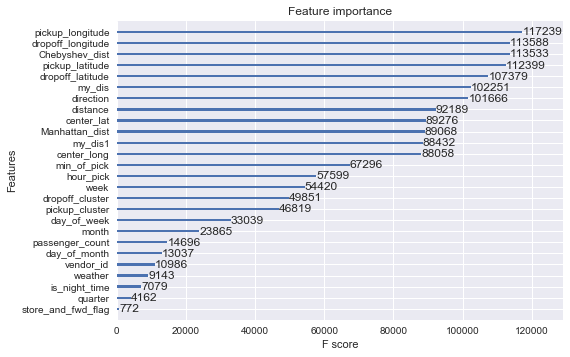

In [39]:
xgb.plot_importance(model, ax=None, height=0.2, xlim=None,
                    ylim=None, title='Feature importance',
                    xlabel='F score', ylabel='Features',
                    importance_type='weight', max_num_features=None,
                    grid=True)
plt.show()


In [40]:
import pickle
pickle.dump(model,open('xgb_14sep.sav','wb'))

In [41]:
model=pickle.load(open('xgb_14sep.sav','rb'))
tst['store_and_fwd_flag']=le.fit_transform(tst['store_and_fwd_flag'])
dtest = xgb.DMatrix(tst)
ytest = model.predict(dtest)
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('xgb_submission_14sep.csv.gz', index=False, compression='gzip')

**More to come.Stay Tunned :  )**

**Please upvote it , if you found my effort useful for you :> **

**Any suggestions are most welcome : )**